# Adding Human-in-the-Loop Functionality to the Agent: Wait for User Input

In this tutorial, we will enhance our chatbot agent by integrating a human-in-the-loop step where the agent waits for user input to proceed. This is particularly useful when the agent needs clarification or additional information from the user before continuing with its task.

For simplicity, we'll use only the Tavily search tool in this tutorial.




### Imports
We start by importing the necessary libraries:

In [1]:
from langchain_openai import ChatOpenAI
from langchain_community.tools import TavilySearchResults
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from pydantic import BaseModel

from typing import Annotated
from typing_extensions import TypedDict

from dotenv import load_dotenv
_ = load_dotenv()


### Setup and Configuration
We define the model, tools, and the graph structure. Take note of the `AskUser` tool, which is used to ask the user clarifying questions. This is a separate node in the graph, and the agent will be interrupted before executing this node.

In [2]:
# Defining the model
llm = ChatOpenAI(model="gpt-4o")

# Defining the search tool
tavily_search = TavilySearchResults(max_results=2)

# this is new
class AskUser(BaseModel):
    """Tool for the agent to ask the user clarifying questions. Use this when you need more information about the user's input."""
    question: str

# List of tools for the agent
tools = [tavily_search, AskUser]

# Binding tools to the LLM
llm_with_tools = llm.bind_tools(tools)

# Defining the StateGraph
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# Defining the nodes
def agent_node(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("agent", agent_node)

tool_node = ToolNode(tools=[tavily_search])
graph_builder.add_node("tool_node", tool_node)

def ask_user_node(state: State):
    """Placeholder node for human interaction."""
    pass  # This node will be interrupted before execution

graph_builder.add_node("ask_user", ask_user_node)


### Defining the Workflow

We define how the agent transitions between nodes and where interruptions occur. In particular, we add a conditional edge that checks the agent's output and decides whether to interrupt at the `ask_user` node or to proceed to the `tool_node`.


In [3]:
# Function to determine the next node based on the agent's output
def routing_condition(state):
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return END
    elif last_message.tool_calls[0]["name"] == "AskUser":
        return "ask_user"
    else:
        return "tool_node"

# Adding conditional edges
graph_builder.add_conditional_edges(
    "agent",
    routing_condition,
    {END: END, "ask_user": "ask_user", "tool_node": "tool_node"}
)

# Defining edges
graph_builder.add_edge("tool_node", "agent")
graph_builder.add_edge("ask_user", "agent")
graph_builder.set_entry_point("agent")


### Setting Up Human-in-the-Loop Interaction
We set up checkpointing for the conversation state and compile the graph with interruption before the ask_user node. This allows the agent to pause and wait for user input.

In [4]:
# Setting up checkpointing for conversation state
memory = MemorySaver()

# Compiling the graph with interruption before 'ask_user' node
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["ask_user"]  # Interrupt before executing 'ask_user' node
)


### Visualizing the Agent's Workflow
We can visualize the agent's workflow using LangGraph's graph visualization tools. This helps us understand how the agent transitions between nodes and where the interruptions occur.



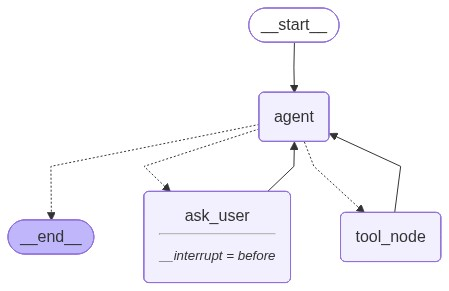

In [5]:
from IPython.display import display, Image

# Visualize the agent's workflow
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass  # Visualization requires additional dependencies


### Testing the Human-in-the-Loop Functionality
Let's test the agent with a query that requires additional information from the user.


In [6]:
# User query that triggers agent to ask for more information
user_input = "What is the weather?"

config = {"configurable": {"thread_id": "1"}}

# Invoking the agent
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()


================================ Human Message =================================

What is the weather?
================================== Ai Message ==================================
Tool Calls:
  AskUser (call_ZCYLYNxdtX8oIWXiCr5BLygu)
 Call ID: call_ZCYLYNxdtX8oIWXiCr5BLygu
  Args:
    question: Could you please specify the location for which you want the weather information?


The agent realizes it needs more information (the specific region for the weather) and attempts to use the AskUser tool to request clarification. 

However, before executing the ask_user node, it interrupts and waits for the user's input.

### Providing User Input
At this point, the agent has paused before executing the ask_user node. We can now provide the user's response.

#### Inspecting the State of the Graph



In [7]:
# Get the current state
snapshot = graph.get_state(config)
print("Next node:", snapshot.next)


Next node: ('ask_user',)


#### Continuing the Conversation with User Input
We simulate the user's response and update the state accordingly.


In [8]:
from langchain_core.messages import ToolMessage

# Get the tool call ID
tool_call_id = snapshot.values["messages"][-1].tool_calls[0]["id"]

# Create a ToolMessage with the user's response
user_response = ToolMessage(
    content="For Singapore",
    tool_call_id=tool_call_id
)

# Update the state with the user's response
graph.update_state(config, {"messages": [user_response]}, as_node="ask_user")


{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f092912-0159-6574-8002-68cc1d5d0c7b'}}

#### Resuming the Agent's Workflow
We can now resume the agent's workflow.

In [9]:
# Continue execution
events = graph.stream(None, config, stream_mode="values")

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()


================================= Tool Message =================================

For Singapore
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_zx2dIoIFtsndcySwcLMZzN2H)
 Call ID: call_zx2dIoIFtsndcySwcLMZzN2H
  Args:
    query: current weather in Singapore
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.weather25.com/asia/singapore?page=month&month=September", "content": "| 28 Patchy rain possible 30° /27° | 29 Patchy rain possible 29° /27° | 30 Light rain shower 30° /26° |  |  |  |  | [...] weather25.com\nSearch\nweather in Singapore\nRemove from your favorite locations\nAdd to my locations\nShare\nweather in Singapore\n\n# Singapore weather in September 2025\n\nPatchy light rain\nLight rain\nPatchy rain possible\nLight rain shower\nPatchy light drizzle\nPatchy rain possible\nPatchy rain possible\nPatchy rain possible

The agent has now used the additional information provided by the user to perform a more specific search and has presented the findings accordingly.

### Conclusion
Congratulations! You've built an AI agent that waits for user input before proceeding with certain actions. This human-in-the-loop interaction allows the agent to:

Pause and ask the user for clarification or additional details.
Resume its workflow after receiving the necessary information.
Provide more accurate and tailored responses based on user input.
This functionality is particularly useful in scenarios where the agent may not have enough information to proceed confidently or when user preferences are essential for the task at hand.

Feel free to experiment further by adding more tools or customizing the interruption logic to suit your specific use cases.